instructions: https://www.cse.chalmers.se/~richajo/dit866/assignments/a3/assignment3.html

# Part 3 - Implementation

Then write a report detailing your implementation, your experiments and your analysis. In particular, some useful issues to discuss might include:

- How much consensus is there between annotators of the dataset? Do you think the data is reliable?

Count those impossible, count this with full consensus, and count those with less than full consensus.  Define reliable, remove those unreliable according to the definition and use that clean and neat dataset for the next step.  

- How do you represent your data as features?

With a TfidfVectorizer (hold frequency as normalized data summing to one). Why do we choose this one over another representation eg. countvectorizer?

- Did you process the features in any way?

Mainly using Tfidfvectorizer hyperparameters. (removed accents and min/max_df for ignoring term below or above thresholds for ex) But there is more

- How did you select which learning algorithms to use?

Tried out a couple of different versions, best scores in falling order are: naive bayes(multinomial 80,5%, gaussian 79,5%),  dummy classifier (51%)

- Did you try to tune the hyperparameters of the learning algorithm, and in that case how?

- How do you evaluate the quality of your system?

- How well does your system compare to a trivial baseline?

- Can you say anything about the errors that the system makes? For a classification task, you may consider a confusion matrix. It is also probably meaningful to include selected errors and comment on what might have gone wrong.

- Is it possible to say something about which features the model considers important? (Whether this is possible depends on the type of classifier you are using.)

## How much consensus is there between annotators of the dataset? Do you think the data is reliable?

Def reliable: consensus on the annotations, not impossible to decide stance (-1) on, 2-4 annotations. Despite lacking any control, annotation with only one entry 

In [1]:
import pandas as pd
import numpy  as np
"""
Start off by filtering all instances with 2 annontations 
and without those that are impossible to annotate (-1) 
That is 30 644 instances with exact 2 annotations, and 32 053 with 2 or less. 

Some instances have as much as 33 annotations, pure duplicates indicate error of some sort
"""
comment_data = pd.read_csv('a3_train_final.tsv', sep='\t', header=None, names=['stance', 'comment'])

stances =[]
comments =[]
nr_agreements =0
i =0

# filter only reliable instances
for stance in comment_data["stance"]:
    lst = stance.split("/")
    if '-1' in lst:
        continue
    if (len(lst) >1 and len(lst) <5):
        
        s= set(lst)
        if (len(s)==1): # consensus
            nr_agreements +=1
            stances.append(s.pop())
            comments.append(comment_data["comment"][i])
            #print(comment_data["comment"][i])
    i+=1

print("Nr of reliable instances is: " + str(nr_agreements) + ". \nWhich is: " + str(nr_agreements/len(comment_data)) + " of the total.")
d = {'stance':stances,'comment':comments}
df = pd.DataFrame(d) 
df

Nr of reliable instances is: 30197. 
Which is: 0.7970700805067968 of the total.


,stance,comment
0,1,I'll only consume if I know what's inside it....
1,0,It is easier to fool a million people than it...
2,1,NATURAL IMMUNITY protected us since evolutio...
3,0,NATURAL IMMUNITY protected us since evolutio...
4,1,The bigest sideffect of vaccines is fewer dea...
...,...,...
30192,0,Yeah no thanks. I'll take my chances with the ...
30193,0,Yeah nope. Not shooting up some mystery vaccine
30194,0,Yeah only the scientist that are funded by Pfi...
30195,0,Yeah right Good luck with pushing that Johnson...


In [2]:
DeepnoteChart(df, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"bar","color":"#4c78a8","tooltip":true},"encoding":{"x":{"sort":null,"type":"nominal","field":"Stance","scale":{"type":"linear"}},"y":{"sort":null,"type":"quantitative","scale":{"type":"linear"},"format":{"type":"default","decimals":null},"aggregate":"count","formatType":"numberFormatFromNumberType"}}}]}],"title":"","config":{"legend":{}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{}}""")

Here we could still discover and document more properties of the data. (Nr of instances with 1, 2 and 3+ annotations)

# Representation and features processing

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Different TfidfVectorizers for processing of the comment to numerical format
tfidf_std = TfidfVectorizer()
tfidf_l1 = TfidfVectorizer(strip_accents='ascii', min_df=0.2, norm='l1') # experiment with parameters
tfidf_l2 = TfidfVectorizer(strip_accents='ascii', min_df=0.2, norm='l2')
tfidf_none = TfidfVectorizer(strip_accents='ascii', min_df=0.2, norm=None)
#tfidf_m1 = TfidfVectorizer(strip_accents='ascii', max_df=1, norm='l1') # choose the max_df
#tfidf_m2 = TfidfVectorizer(strip_accents='ascii', max_df=0.7, norm='l1') # choose the max_df

# NO NEED FOR THESE WITH PIPELINE?
feature_matrix_std = tfidf_std.fit_transform(df['comment'])
feature_matrix_l1 = tfidf_l1.fit_transform(df['comment'])
feature_matrix_l2 = tfidf_l2.fit_transform(df['comment'])
feature_matrix_none = tfidf_none.fit_transform(df['comment'])


"""" MORE OVER
# dimensionality reduction --> feature selcetion and manny more techniques
# standardization of instances or features 
# stop word removal --> with Tfidf: max_df can be set to a value in the range [0.7, 1.0) to automatically detect and filter stop words based on intra corpus document frequency of terms.
# stemming 
"""

'" MORE OVER\n# dimensionality reduction --> feature selcetion and manny more techniques\n# standardization of instances or features \n# stop word removal --> with Tfidf: max_df can be set to a value in the range [0.7, 1.0) to automatically detect and filter stop words based on intra corpus document frequency of terms.\n# stemming \n'

# Select learning algo

From the first data set 
#try with different linear classifiers [SVC, KNN, SVC & ensemble] 
#best linearSVC: linearSVC() --> 0.73...
#best KNN: KNeighborsClassifier(n_neighbors=15,weights='distance') --> 0.7436
#best SVC: SVC() --> 0.7077


In [4]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

#Splitting the training data
X_train, X_test, Y_train, Y_test = train_test_split(
    df['comment'], df['stance'], test_size=0.2, random_state=1)

def train_and_score_classifier(vectorizer, classifier):
    pipeline = Pipeline([('vectorizer', vectorizer), ('classifier', classifier)])
    pipeline.fit(X_train, Y_train)
    test_score = pipeline.score(X_test, Y_test)
    cross_vs = cross_val_score(pipeline, df['comment'], df['stance'])
    res_str = ("Test score of: " + str(test_score)+" ||  Cross validation score of: " + str(cross_vs.mean()) 
    + ", using " +str(vectorizer)    + "and "+str(classifier))
    print(res_str)

"""
# Boiler plate
def test_rig():
    results = []
    for k in ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']:
        res_str, test_score, classifier = train_and_score_classifier(TfidfVectorizer(), SVC(kernel=k))  
        results.append(res_str)
    return results
"""

"\n# Boiler plate\ndef test_rig():\n    results = []\n    for k in ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']:\n        res_str, test_score, classifier = train_and_score_classifier(TfidfVectorizer(), SVC(kernel=k))  \n        results.append(res_str)\n    return results\n"

In [5]:
from sklearn.dummy import DummyClassifier
# Dummy test --> baseline of ≈51%, also showing that we have class balance

train_and_score_classifier(tfidf_std, DummyClassifier(strategy = 'most_frequent') )

Test score of: 0.5097682119205298 ||  Cross validation score of: 0.5062423387056978, using TfidfVectorizer()and DummyClassifier(strategy='most_frequent')


### Naive Bayes

In [6]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

""" Tuning with 
For tfidf
-  strip_accents='ascii'
- different norms
- 

MNB specific
- fit_prior bool, default=True         
- alpha float or array-like of shape (n_features,), default=1.0

"""

# MultinomialNB
def test_rig_MNB():
    for n in ['l1','l2', None]: # norms
        for a in [0.01, 0.1, 0.5, 1]: # alphas 
            train_and_score_classifier(vectorizer= TfidfVectorizer(strip_accents='ascii', norm=n), classifier= MultinomialNB(alpha=a))  
        """
        for max in [1.0, 0.7]: #max_df
            for min in [0.1,0.2]: #min_df        
                
                """
        
            
#print(*results,sep = "\n")
test_rig_MNB()


Test score of: 0.5198675496688742 ||  Cross validation score of: 0.4849163768835901, using TfidfVectorizer(norm='l1', strip_accents='ascii')and MultinomialNB(alpha=0.01)
Test score of: 0.5173841059602649 ||  Cross validation score of: 0.48455221523672287, using TfidfVectorizer(norm='l1', strip_accents='ascii')and MultinomialNB(alpha=0.1)
Test score of: 0.5251655629139073 ||  Cross validation score of: 0.4872345373175902, using TfidfVectorizer(norm='l1', strip_accents='ascii')and MultinomialNB(alpha=0.5)
Test score of: 0.5266556291390728 ||  Cross validation score of: 0.487366888952493, using TfidfVectorizer(norm='l1', strip_accents='ascii')and MultinomialNB(alpha=1)


KeyboardInterrupt: 

In [ ]:
# GaussianNB
""" Tuning with 
var_smoothing float, default=1e-9

"""

def test_rig_NB():

    for a in [1e-9, 1e-5, 1e-1]:
        train_and_score_classifier(TfidfVectorizer(), GaussianNB(var_smoothing=a))  
        
#print(*test_rig_NB(),sep = "\n")

silent = test_rig_NB()

### SVC

In [ ]:
#from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
"""
# Different SVCs
Accuracy score of: 0.5370860927152318, using SVC()

"""
def test_rig_SVC():
    results = []
    for k in ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']:
        res_str, test_score, classifier = train_and_score_classifier(TfidfVectorizer(), SVC(kernel=k))  
        print(res_str)
        results.append(res_str)
        
    return results

print(test_rig_SVC())

# I get: 
#ValueError: too many values to unpack (expected 3) --> due to train_and_score_classifier


ValueError: too many values to unpack (expected 3)

### KN Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# KN_classifier --> standardizing not necessary when using a vectorizer due to pretty uniform values. 

def test_rig_KNC():
    results = []
    for k in range(2,50+1,5):
        #results.append(k)
        
        res_str, test_score, classifier = train_and_score_classifier(TfidfVectorizer(), 
        KNeighborsClassifier(n_neighbors=k, weights='distance',n_jobs=-1))  
        results.append([test_score, classifier])
        print(res_str)
        
    return results
#print(*test_rig_KNC(),sep = "\n")

silent = test_rig_KNC()


Accuracy score of: 0.5150662251655629, using KNeighborsClassifier(n_jobs=-1, n_neighbors=2, weights='distance')

Accuracy score of: 0.5225165562913907, using KNeighborsClassifier(n_jobs=-1, n_neighbors=7, weights='distance')

Accuracy score of: 0.526158940397351, using KNeighborsClassifier(n_jobs=-1, n_neighbors=12, weights='distance')

Accuracy score of: 0.5173841059602649, using KNeighborsClassifier(n_jobs=-1, n_neighbors=17, weights='distance')

Accuracy score of: 0.5129139072847683, using KNeighborsClassifier(n_jobs=-1, n_neighbors=22, weights='distance')

Accuracy score of: 0.508774834437086, using KNeighborsClassifier(n_jobs=-1, n_neighbors=27, weights='distance')

Accuracy score of: 0.5139072847682119, using KNeighborsClassifier(n_jobs=-1, n_neighbors=32, weights='distance')

Accuracy score of: 0.518046357615894, using KNeighborsClassifier(n_jobs=-1, n_neighbors=37, weights='distance')

Accuracy score of: 0.5160596026490066, using KNeighborsClassifier(n_jobs=-1, n_neighbors=42,

In [ ]:
for i in range(2,2+1,1):
    print(i)

2


## Evaluation 

sklearn.metrics.classification_report seems like a nice tool for fscore, recall, precision and support data

### Confusion matrix

ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (975).

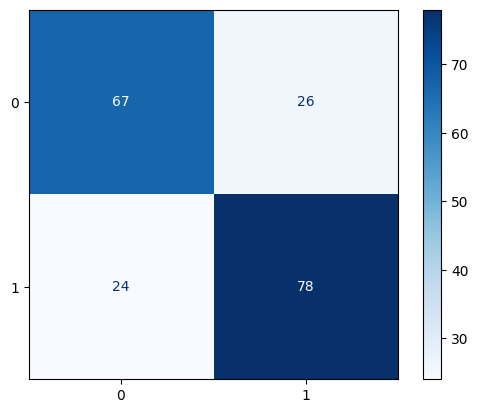

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true = Y_test
y_pred = clf.predict(X_test)
#confusion_matrix(y_true, y_pred) # pure computation
class_names = comment_data.stance

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        Y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

# initial testing of different vectorizers

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

Y = comment_data.stance

vectorizer1 = CountVectorizer()
X_v1 = vectorizer1.fit_transform(comment_data.comment)
vectorizer2 = TfidfVectorizer()
X_v2 = vectorizer2.fit_transform(comment_data.comment)

X_v1.shape #(975, 3343), same for both

(975, 3343)

In [ ]:
from sklearn.linear_model import Perceptron
from sklearn.model_selection import cross_val_score

# linear classifier 

cross_val_score(Perceptron(), X_v1, Y, cv=4).mean()

0.7333114079471093

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f93a499e-42e4-47ba-a697-a51a595d57fe' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>